## 자연어 처리 딥러닝
# 주가 분석
- https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS (삼성전자)
- https://finance.yahoo.com/quote/%5EKS11/history?p=%5EKS11 (KOSPI)
- https://finance.yahoo.com/quote/035420.KS/history?p=035420.KS (Naver)

- https://m.blog.naver.com/tkdlqm2/221575377059
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras

In [2]:
stock_df = pd.read_csv('samsung_005930.KS.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-02,21400.0,21600.0,21300.0,21600.0,17500.316406,13151350
1,2012-01-03,21860.0,22100.0,21840.0,22100.0,17905.416016,16927750
2,2012-01-04,22100.0,22200.0,21500.0,21600.0,17500.316406,17103700
3,2012-01-05,21460.0,21580.0,21100.0,21100.0,17095.216797,17298400
4,2012-01-06,21120.0,21320.0,20600.0,20800.0,16852.156250,18816250


In [3]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2567,2022-06-13,62400.0,62800.0,62100.0,62100.0,62100.0,22157816
2568,2022-06-14,61200.0,62200.0,61100.0,61900.0,61900.0,24606419
2569,2022-06-15,61300.0,61500.0,60200.0,60700.0,60700.0,26811224
2570,2022-06-16,61300.0,61800.0,60500.0,60900.0,60900.0,23394895
2571,2022-06-17,59400.0,59900.0,59400.0,59800.0,59800.0,29053450


In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2572 non-null   object 
 1   Open       2572 non-null   float64
 2   High       2572 non-null   float64
 3   Low        2572 non-null   float64
 4   Close      2572 non-null   float64
 5   Adj Close  2572 non-null   float64
 6   Volume     2572 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 140.8+ KB


In [5]:
stock_df = stock_df.dropna() # 2019.8.2 데이터가 비어있음

In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2572 entries, 0 to 2571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2572 non-null   object 
 1   Open       2572 non-null   float64
 2   High       2572 non-null   float64
 3   Low        2572 non-null   float64
 4   Close      2572 non-null   float64
 5   Adj Close  2572 non-null   float64
 6   Volume     2572 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 140.8+ KB


In [7]:
stock_df['average'] = (stock_df['High'] + stock_df['Low'])/2

In [8]:
stock_df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,average
0,2012-01-02,21400.0,21600.0,21300.0,21600.0,17500.316406,13151350,21450.0
1,2012-01-03,21860.0,22100.0,21840.0,22100.0,17905.416016,16927750,21970.0


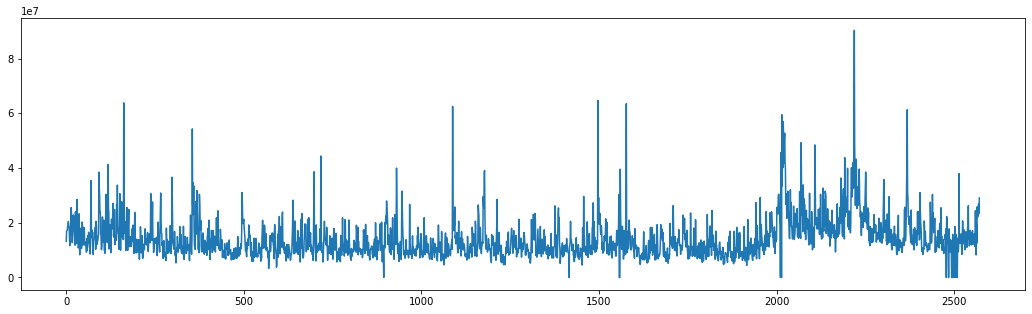

In [9]:
plt.figure(figsize=(18,5))
plt.plot(stock_df['Volume'])
#plt.ylim(0,1000000)

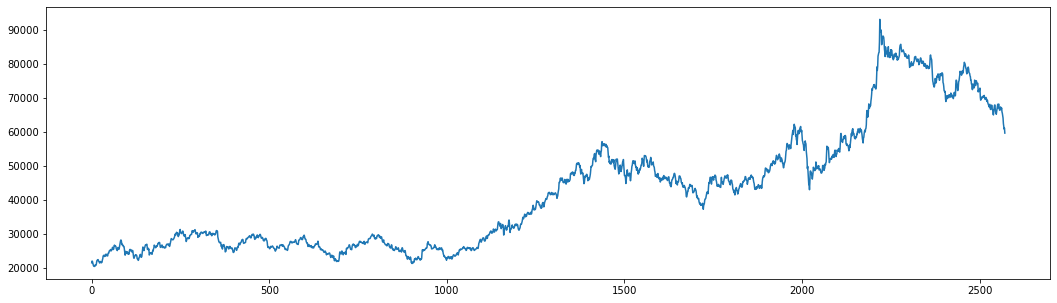

In [10]:
plt.figure(figsize=(18,5))
plt.plot(stock_df['average'])

- 거래량과 일별평균주가로 데이터를 만든다

In [11]:
stock = stock_df[['Volume','average']].values
stock.shape

(2572, 2)

### 학습용 데이터 생성

In [12]:
stock.shape

(2572, 2)

In [13]:
lookback = 50 # 50일치 데이터로 시퀀스를 만든다

In [14]:
X = []
y = []

for i in range(len(stock)-lookback):
    X.append(stock[i:i+lookback])
    y.append(stock[i+lookback,[1]])

In [45]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((2522, 50, 2), (2522, 1))

In [46]:
X_train = X[:-200-lookback]
X_test = X[-200:]
y_train = y[:-200-lookback]
y_test = y[-200:]

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2272, 50, 2), (200, 50, 2), (2272, 1), (200, 1))

- 각 샘플 별로 정규화 적용

In [48]:
X = []
Y = []

for x,y in zip(X_train, y_train):
    x_mean = x.mean(axis=0)
    x_std = x.std(axis=0)
    X.append((x-x_mean)/x_std)
    Y.append([(y[0]-x_mean[1])/x_std[1]])

In [49]:
np.array(X).shape, np.array(Y).shape

((2272, 50, 2), (2272, 1))

In [50]:
X_train = np.array(X)
y_train = np.array(Y)

In [51]:
X = []
Y = []

for x,y in zip(X_test, y_test):
    x_mean = x.mean(axis=0)
    x_std = x.std(axis=0)
    X.append((x-x_mean)/x_std)
    Y.append([(y[0]-x_mean[1])/x_std[1]])
    
X_test = np.array(X)
y_test = np.array(Y)

In [52]:
X_test.shape, y_test.shape

((200, 50, 2), (200, 1))

### 모델 생성

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization

In [54]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu',
              input_shape=(50,2))) # ReLU 적용 (회귀)
model.add(LSTM(32, return_sequences=True, activation='relu')) # ReLU 적용 (회귀)
model.add(LSTM(32))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 32)            4480      
                                                                 
 lstm_1 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,153
Trainable params: 21,153
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(loss='mse', optimizer='adam')

In [56]:
h = model.fit(X_train, y_train, batch_size=32, epochs=20,
              validation_data=(X_test, y_test))

Epoch 1/20
71/71 [==============================] - 8s 65ms/step - loss: 1.2672 - val_loss: 0.7001
Epoch 2/20
71/71 [==============================] - 3s 43ms/step - loss: 0.5601 - val_loss: 0.2227
Epoch 3/20
71/71 [==============================] - 3s 44ms/step - loss: 0.2726 - val_loss: 0.1678
Epoch 4/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1909 - val_loss: 0.1399
Epoch 5/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1715 - val_loss: 0.1641
Epoch 6/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1700 - val_loss: 0.1446
Epoch 7/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1643 - val_loss: 0.1271
Epoch 8/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1724 - val_loss: 0.1283
Epoch 9/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1604 - val_loss: 0.1250
Epoch 10/20
71/71 [==============================] - 3s 43ms/step - loss: 0.1649 - val_loss: 0.1307
Epoch 11/

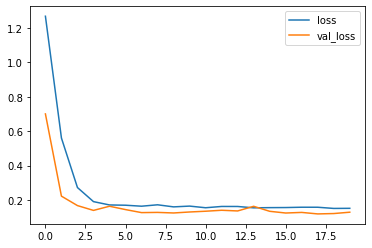

In [57]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])

### 평가

In [58]:
X = []
y = []

for i in range(len(stock)-lookback):
    X.append(stock[i:i+lookback])
    y.append(stock[i+lookback,[1]])

In [59]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((2522, 50, 2), (2522, 1))

In [60]:
_X_train = X[:-200-lookback]
_X_test = X[-200:]
_y_train = y[:-200-lookback]
_y_test = y[-200:]

In [61]:
_X_train.shape, _X_test.shape, _y_train.shape, _y_test.shape

((2272, 50, 2), (200, 50, 2), (2272, 1), (200, 1))

In [62]:
pred_y = model.predict(X_test)
pred_y

array([[-3.02150846e+00],
       [-2.90803742e+00],
       [-2.52007270e+00],
       [-1.88443828e+00],
       [-1.46194720e+00],
       [-1.56736219e+00],
       [-1.87618315e+00],
       [-1.63818228e+00],
       [-1.30407274e+00],
       [-8.99104655e-01],
       [-9.93319631e-01],
       [-8.84042919e-01],
       [-4.99556184e-01],
       [-7.85679936e-01],
       [-8.97479475e-01],
       [-8.81448269e-01],
       [-1.08656728e+00],
       [-8.01860690e-01],
       [ 2.72186473e-04],
       [-3.61552656e-01],
       [-3.73010159e-01],
       [-3.76407921e-01],
       [ 2.45340187e-02],
       [ 1.99385453e-02],
       [-2.60288399e-02],
       [-1.49008855e-01],
       [-1.35797668e+00],
       [-1.18942487e+00],
       [-1.44377184e+00],
       [-1.94505024e+00],
       [-1.82167971e+00],
       [-1.83633685e+00],
       [-1.67134678e+00],
       [-2.39744663e+00],
       [-2.37842321e+00],
       [-2.08748507e+00],
       [-1.57142782e+00],
       [-1.78141582e+00],
       [-1.4

In [63]:
real_y = []

for i in range(200):
    x = _X_test[i]
    real_y.append(pred_y[i]*(x.std(axis=0)[1]) + x.mean(axis=0)[1])

In [64]:
real_y = np.array(real_y)

Text(0.5, 1.0, 'Samsung - Stock price')

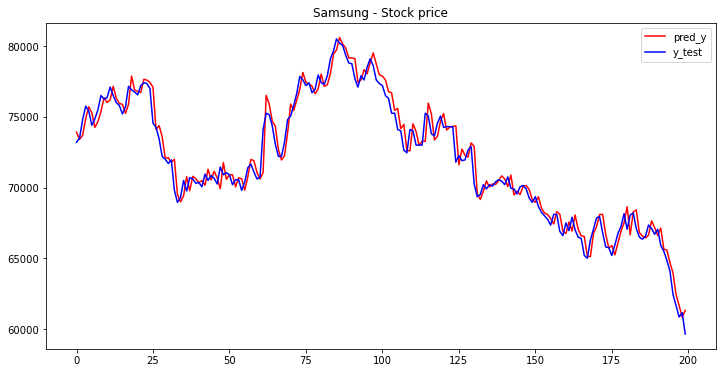

In [65]:
plt.figure(figsize=[12,6])
plt.plot(real_y.ravel(), 'r-', label='pred_y')
plt.plot(_y_test.ravel(), 'b-', label='y_test')
#plt.plot((real_y-_y_test).ravel()*50, 'g-', label='diff*10')
plt.legend()
plt.title('Samsung - Stock price')

- 위의 결과는 그럴듯해 보이지만 사실은 엉터리이다
- 바로 하루전의 주가로 예측한 것일 뿐이다

Text(0.5, 1.0, 'Samsung - Stock price')

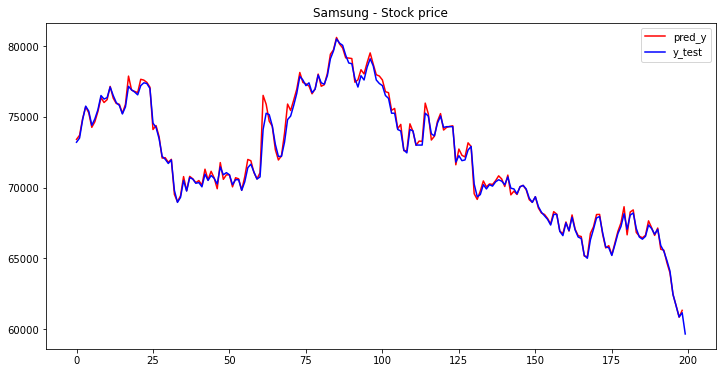

In [68]:
plt.figure(figsize=[12,6])
plt.plot(real_y.ravel()[1:], 'r-', label='pred_y')
plt.plot(_y_test.ravel(), 'b-', label='y_test')
#plt.plot((real_y-_y_test).ravel()*50, 'g-', label='diff*10')
plt.legend()
plt.title('Samsung - Stock price')